# AFM Tomography Reconstruction Interactive Notebook

This notebook loads AFM profile images (with an embedded colorbar) from the `AFM_Tomo/data` directory, removes the unwanted colorbar from the right, extracts the central row from each cropped image, and dynamically visualizes the 2D profile stack. A slider lets you select the depth slice to view its 1D AFM profile.

Make sure that your images are named with the depth in microns (e.g. `profile_3um.png`) so that the notebook can sort them correctly.

In [1]:
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import ipywidgets as widgets
from ipywidgets import interactive

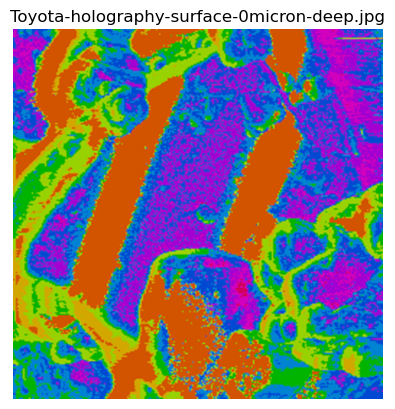

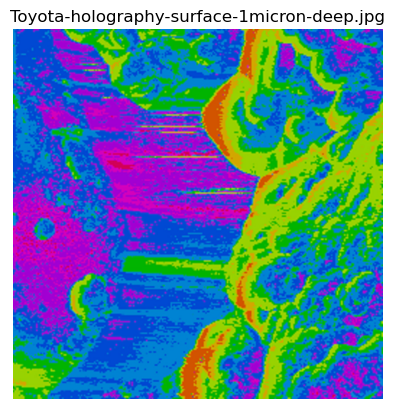

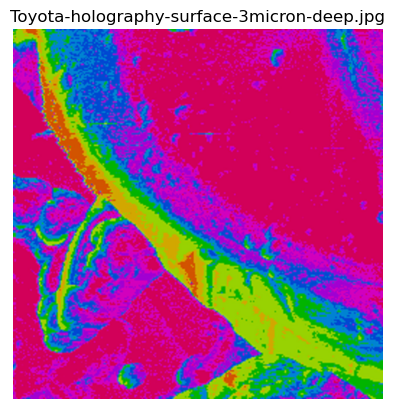

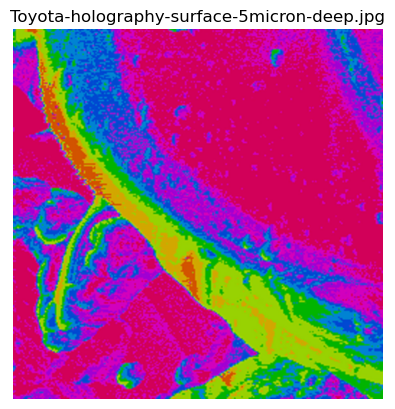

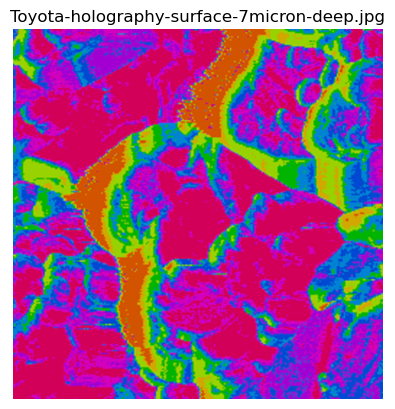

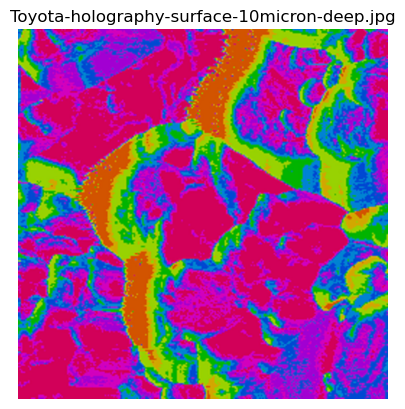

In [6]:
file_list = glob.glob(os.path.join("data", "*.jpg"))
if not file_list:   
    print("No jpg files found in the data folder.")
else:
    # Sort files based on the numerical value in the filename
    sorted_files = sorted(file_list, 
                         key=lambda fp: float(re.findall(r"(\d+\.?\d*)", os.path.basename(fp))[0]))
    
    for filepath in sorted_files:
        img = io.imread(filepath)
        plt.figure()
        plt.imshow(img, cmap='gray')
        plt.title(os.path.basename(filepath))
        plt.axis('off')
        plt.show()

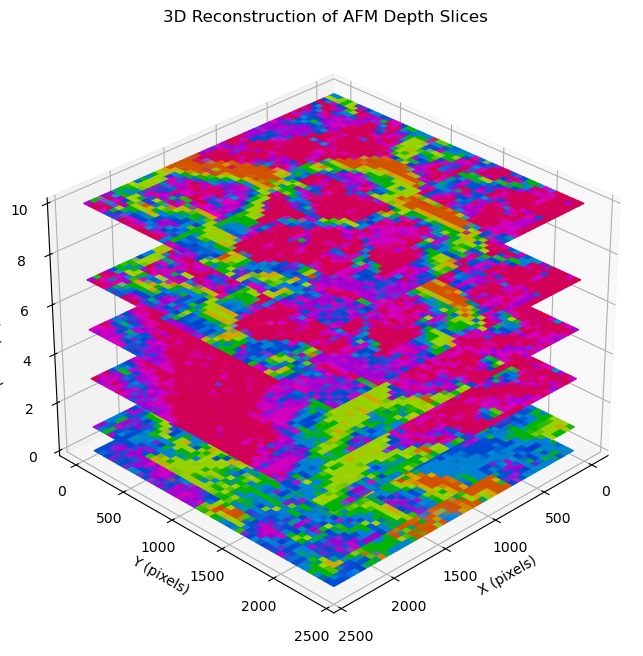

In [8]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# First, let's collect all images and their depths into arrays
images = []
depths = []

for filepath in sorted_files:
    # Extract depth from filename
    depth = float(re.findall(r"(\d+\.?\d*)", os.path.basename(filepath))[0])
    img = io.imread(filepath)
    
    # Normalize image to [0,1] range
    img_normalized = img.astype(float) / 255.0
    
    images.append(img_normalized)
    depths.append(depth)

# Convert to numpy arrays
images = np.array(images)
depths = np.array(depths)

# Create meshgrid for 3D plotting
y, x = np.mgrid[0:images[0].shape[0], 0:images[0].shape[1]]

# Create 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each slice
for i, (img, depth) in enumerate(zip(images, depths)):
    stride = 5  # Adjust this value based on your image size
    
    # Create color array for this slice
    colors = np.zeros((x[::stride, ::stride].shape[0], x[::stride, ::stride].shape[1], 4))
    colors[:, :, :3] = img[::stride, ::stride, np.newaxis] if len(img.shape) == 2 else img[::stride, ::stride]
    colors[:, :, 3] = 1.0  # Alpha channel
    
    surf = ax.plot_surface(x[::stride, ::stride],
                          y[::stride, ::stride],
                          np.full_like(x[::stride, ::stride], depth),
                          facecolors=colors,
                          shade=False)

ax.set_xlabel('X (pixels)')
ax.set_ylabel('Y (pixels)')
ax.set_zlabel('Depth (microns)')
ax.set_title('3D Reconstruction of AFM Depth Slices')

# Adjust the view angle for better visualization
ax.view_init(elev=30, azim=45)

plt.show()

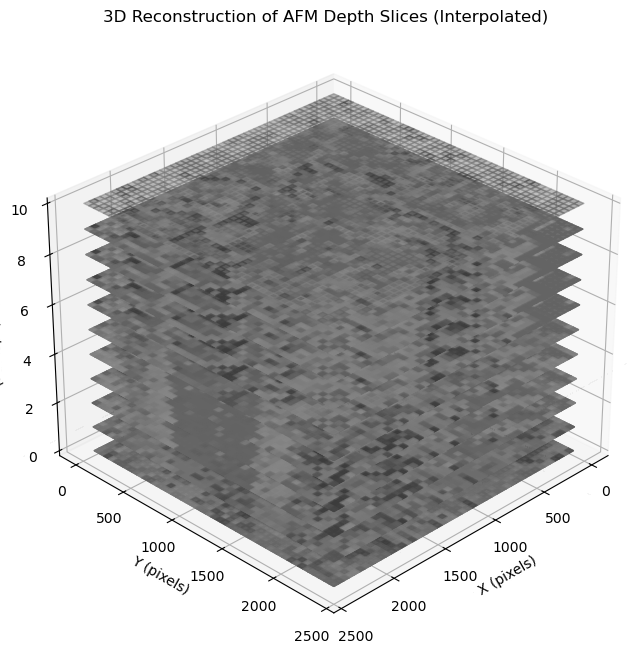

In [10]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp2d

# First, let's collect all images and their depths into arrays
images = []
depths = []

for filepath in sorted_files:
    depth = float(re.findall(r"(\d+\.?\d*)", os.path.basename(filepath))[0])
    img = io.imread(filepath)
    
    # Convert to grayscale if image is RGB
    if len(img.shape) == 3:
        img = np.mean(img, axis=2)  # Convert RGB to grayscale by averaging channels
    
    img_normalized = img.astype(float) / 255.0
    images.append(img_normalized)
    depths.append(depth)

# Convert to numpy arrays
images = np.array(images)
depths = np.array(depths)

# Create a finer depth sampling
num_interpolated_slices = 50  # Adjust this number to control smoothness
depths_interpolated = np.linspace(depths.min(), depths.max(), num_interpolated_slices)

# Now images[0].shape should be 2D
height, width = images[0].shape
interpolated_images = np.zeros((num_interpolated_slices, height, width))

# Create coordinate grids for original image
y_coords = np.arange(height)
x_coords = np.arange(width)

# Interpolate each pixel across depths
for i in range(height):
    for j in range(width):
        pixel_values = images[:, i, j]
        # Create interpolation function for this pixel
        interp_func = np.interp(depths_interpolated, depths, pixel_values)
        interpolated_images[:, i, j] = interp_func

# Create meshgrid for 3D plotting
y, x = np.mgrid[0:height, 0:width]

# Create 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each interpolated slice
stride = 5  # Adjust this value based on your image size
for i, (img, depth) in enumerate(zip(interpolated_images, depths_interpolated)):
    colors = np.zeros((x[::stride, ::stride].shape[0], x[::stride, ::stride].shape[1], 4))
    colors[:, :, :3] = img[::stride, ::stride, np.newaxis]
    colors[:, :, 3] = 0.5  # Added some transparency to see through layers
    
    surf = ax.plot_surface(x[::stride, ::stride],
                          y[::stride, ::stride],
                          np.full_like(x[::stride, ::stride], depth),
                          facecolors=colors,
                          shade=False)

ax.set_xlabel('X (pixels)')
ax.set_ylabel('Y (pixels)')
ax.set_zlabel('Depth (microns)')
ax.set_title('3D Reconstruction of AFM Depth Slices (Interpolated)')

# Adjust the view angle for better visualization
ax.view_init(elev=30, azim=45)

plt.show()